## Fitting the data

In [305]:
from pyLIMA import event
from pyLIMA import telescopes
from pyLIMA.models import FSPLarge_model
from pyLIMA.outputs import pyLIMA_plots
from pyLIMA.fits import DE_fit, MCMC_fit
import matplotlib.pyplot as plt
import numpy as np
import corner


In [315]:
data = np.load('../tutorials/assets/microlensing_dat.npz')['data']

# Microlensing Model Parameters
u0 = 0.8 # minimum impact parameter (u(t=t_0))
t0 = 0.2 # time at peak magnification
tE = 0.1/2 # Einstein timescale #! Note that the PyLIMA definition of tE is time to cross the full Einstein ring (i.e. 2 * the einstein Radius)

# Microlensing Physical Parameters
th_ein = 0.5 # Einstein radius in arcsec
rho = 2.0 # source size in units of lens Einstein radii

gamma = 0.5 # linear limb darkening coefficient

In [316]:
your_event = event.Event()
pspl_event = event.Event() #todo add pspl fit?
your_event.name = 'Simulated Event'
telescope = telescopes.Telescope(name= 'test', light_curve=data, light_curve_names=['time', 'mag', 'err_mag'], light_curve_units=['s', 'mag', 'err_mag'])
# telescope_pspl = telescopes.Telescope(name= 'test', light_curve=data, light_curve_names=['time', 'mag', 'err_mag'], light_curve_units=['s', 'mag', 'err_mag'])

your_event.telescopes.append(telescope)
# your_event.telescopes[0].ld_gamma = 0.5
your_event.find_survey('test')
your_event.check_event()


# pspl = PSPL_model.PSPLmodel(your_event)
fspl = FSPLarge_model.FSPLargemodel(your_event)
# fspl = FSPL_model.FSPLmodel(your_event)
# pspl_fit = LM_fit.LMfit(pspl)
fspl_fit = DE_fit.DEfit(fspl, DE_population_size=10, loss_function='chi2', max_iteration=10000)

check_event  : Everything looks fine...


In [317]:
# t_E  u0   tE  rho
fspl_fit.fit_parameters['tE'][1] = (0.0, 2)
fspl_fit.fit_parameters['u0'][1] = (0.0, 2)
fspl_fit.fit_parameters['rho'][1] = [0.1,10]
guess_parameters = [0.2, 0.3, 0.3, 1]
fspl_fit.model_parameters_guess = guess_parameters

# pspl_fit.fit()
fspl_fit.fit()


DE converge to objective function : f(x) =  60.142759986028125
DE converge to parameters : =  ['0.20008893877401898' '1.948859941695436' '0.042646355968257166'
 '2.2962145461099848']
fit  : Differential Evolution fit SUCCESS
best_model: [0.20008894 1.94885994 0.04264636 2.29621455] chi2 60.142759986028125


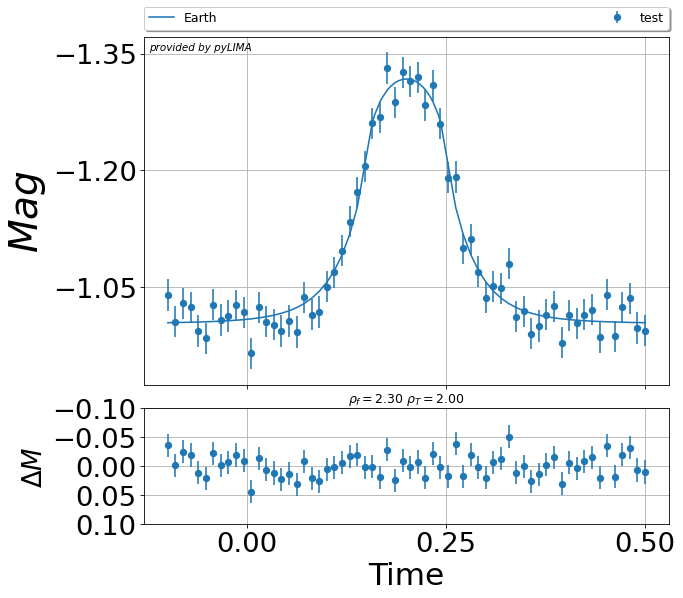

In [318]:
fig = pyLIMA_plots.plot_lightcurves(fspl, fspl_fit.fit_results['best_model'])

# plt.xlim(-3*tE+t0,3*tE+t0)
plt.title(r'$\rho_f = {:.2f}$'.format(fspl_fit.fit_results['best_model'][3]) + r' $\rho_T = {:.2f}$'.format(rho))
plt.xlabel('Time', fontsize=30)
plt.show()

### MCMC

In [319]:
fspl_mcmc_fit = MCMC_fit.MCMCfit(fspl, MCMC_walkers=4, loss_function='chi2')
fspl_mcmc_fit.fit_parameters['t0'][1] = (-1, 1)
fspl_mcmc_fit.fit_parameters['tE'][1] = (0.0, 2)
fspl_mcmc_fit.fit_parameters['u0'][1] = (0.0, rho)
fspl_mcmc_fit.fit_parameters['rho'][1] = [0.0, 10]
# guess_parameters = [0.2, 0.3, 0.3, 2.5]
# fspl_mcmc_fit.model_parameters_guess = guess_parameters
#Initialize MCMC with best parameters of DE fit
fspl_mcmc_fit.model_parameters_guess = fspl_fit.fit_results['best_model']

fspl_mcmc_fit.fit()

initial_guess  : Initial parameters guess SUCCESS
Using guess:  [0.20008893877401898, 1.948859941695436, 0.042646355968257166, 2.2962145461099848]


100%|██████████| 5000/5000 [00:15<00:00, 317.07it/s]


fit  : Monte Carlo Markov Chain (Affine Invariant) fit SUCCESS
best_model: [ 2.00011573e-01  1.98663339e+00  4.20196998e-02  2.33748667e+00
  3.24246429e+11 -9.44370354e+10] chi2 -60.09222079975092


In [326]:
MCMC_results = fspl_mcmc_fit.fit_results['MCMC_chains']
print('Parameters', ' Model', '   Fit', '     Errors')
print('-----------------------------------')
print('t_0:', '        ' + str(t0)+'  ', str(np.median(MCMC_results[1000:, :, 0]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 0]))[:7])
print('u_0:', '        ' + str(u0)+'  ', str(np.median(MCMC_results[1000:, :, 1]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 1]))[:7])
print('t_E:', '        ' + str(tE)+' ', str(np.median(MCMC_results[1000:, :, 2]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 2]))[:7])
print('rho:', '        ' + str(rho)+'  ', str(np.median(MCMC_results[1000:, :, 3]))[:7], '',
      str(np.std(MCMC_results[1000:, :, 3]))[:7])

Parameters  Model    Fit      Errors
-----------------------------------
t_0:         0.2   0.20014  0.00100
u_0:         0.8   1.52359  0.44286
t_E:         0.05  0.04732  0.00773
rho:         2.0   1.90015  0.39620


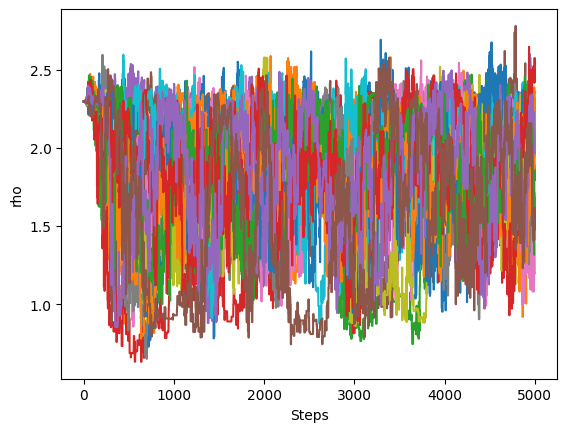

In [327]:
plt.plot(fspl_mcmc_fit.fit_results['MCMC_chains'][:,:,3])
plt.xlabel('Steps')
plt.ylabel('rho')
plt.show()

In [328]:
burn_in = 1000
MCMC_results_pruned = MCMC_results[burn_in:, :, :]
reshaped_results = MCMC_results_pruned.reshape(-1, 5)

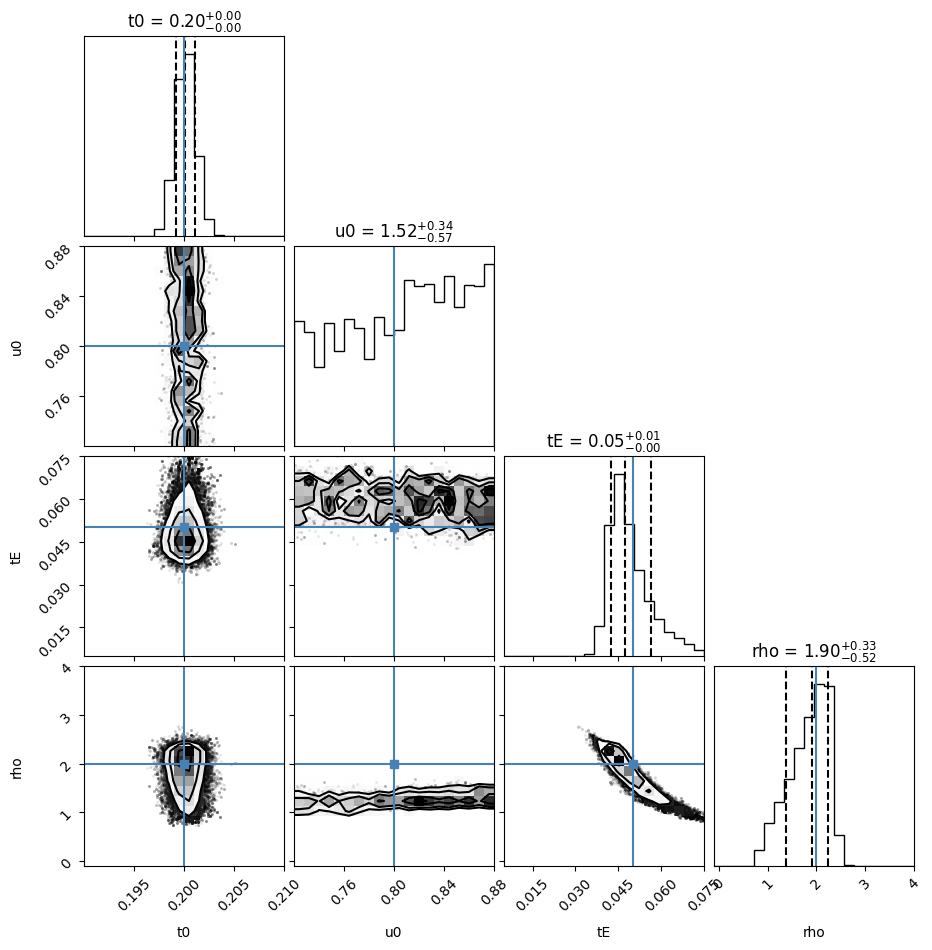

In [329]:
fspl_mcmc_fit.fit_parameters.keys()
figure = corner.corner(reshaped_results[:,0:4], labels=[label for label in fspl_mcmc_fit.fit_parameters.keys()],
                       quantiles=[0.16,0.5, 0.84], 
                       truths=[t0, u0, tE, rho], 
                       show_titles=True,
                       range=[(0.95*t0, 1.05*t0), (0.9*u0, 1.1*u0), (0.1*tE, 1.5*tE), (-0.1, 2*rho)]
                       )


In [324]:
mcmc_best_fit_params = np.median(reshaped_results, axis=0)

true_parameters = [t0, u0, tE, rho]

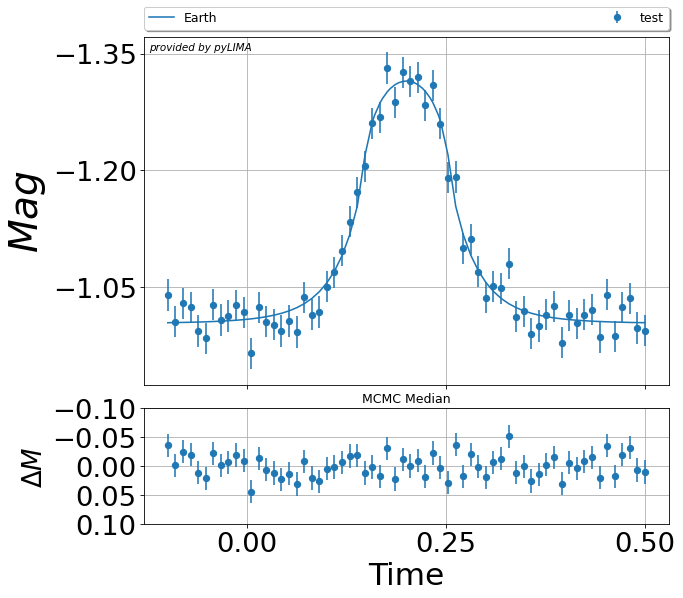

In [325]:
fig = pyLIMA_plots.plot_lightcurves(fspl, mcmc_best_fit_params[:4])

plt.title("MCMC Median")
plt.xlabel('Time', fontsize=30)
plt.show()